# Multivariate Time Series Forecasting with Transformers 
Dataset: http://bit.ly/covid19-poland

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import math
import networkx
import seaborn
import sklearn
from tabulate import tabulate
import matplotlib.dates as dates
from datetime import datetime

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data as data
import math
from sklearn.preprocessing import MinMaxScaler
from datetime import date, timedelta, datetime
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns

## Load dataset

In [3]:
df = pd.read_csv('/kaggle/input/dsdsds/DataSets/COVID-19_w_Polsce-Wzrost.csv', sep=';', usecols=["Data", "Nowe przypadki", "Zmiana liczby aktywnych przypadków"])
print(df.head())
print(df.tail())
print(f"Number of records: {len(df)}")
print("Labels types:")
print(f"{df.dtypes}")

# table = df.values.tolist()
# headers = df.columns.tolist()
# print(tabulate(table, headers=headers, tablefmt="pretty"))

# styled_df = df.style.format('{:^10}').set_properties(**{'border': '1px solid black', 'text-align': 'center'}).set_table_styles([{'selector': 'th', 'props': [('border', '1px solid black')]}])
# styled_df

   Data Nowe przypadki Zmiana liczby aktywnych przypadków
0  3.03            + 0                                + 0
1  4.03            + 1                                + 1
2  5.03            + 0                                + 0
3  6.03            + 4                                + 4
4  7.03            + 1                                + 1
      Data Nowe przypadki Zmiana liczby aktywnych przypadków
738  11.03        + 11637                              2 917
739  12.03            NaN                          5 169 557
740    NaN            NaN                                NaN
741    NaN            NaN                                NaN
742    NaN            NaN                                NaN
Number of records: 743
Labels types:
Data                                  float64
Nowe przypadki                         object
Zmiana liczby aktywnych przypadków     object
dtype: object


## Data preprocessing

### Remove NaNs

In [4]:
df = df.dropna()
# for index, row in df.iterrows():
#     if pd.isna(row['Data']):
#         df.drop(index, inplace=True)
print(f"Number of records after dropping all NaNs: {len(df)}")
df

Number of records after dropping all NaNs: 739


,Data,Nowe przypadki,Zmiana liczby aktywnych przypadków
0,3.03,+ 0,+ 0
1,4.03,+ 1,+ 1
2,5.03,+ 0,+ 0
3,6.03,+ 4,+ 4
4,7.03,+ 1,+ 1
...,...,...,...
734,7.03,+ 5585,-6 470
735,8.03,+ 13152,2 945
736,9.03,+ 14415,4 355
737,10.03,+ 13438,4 794


### Convert types

In [5]:
def is_string(value):
    return isinstance(value, str)
result = df.applymap(is_string)
print(result)

      Data  Nowe przypadki  Zmiana liczby aktywnych przypadków
0    False            True                                True
1    False            True                                True
2    False            True                                True
3    False            True                                True
4    False            True                                True
..     ...             ...                                 ...
734  False            True                                True
735  False            True                                True
736  False            True                                True
737  False            True                                True
738  False            True                                True

[739 rows x 3 columns]


/tmp/ipykernel_34/3806100412.py:3: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  result = df.applymap(is_string)


In [6]:
df

,Data,Nowe przypadki,Zmiana liczby aktywnych przypadków
0,3.03,+ 0,+ 0
1,4.03,+ 1,+ 1
2,5.03,+ 0,+ 0
3,6.03,+ 4,+ 4
4,7.03,+ 1,+ 1
...,...,...,...
734,7.03,+ 5585,-6 470
735,8.03,+ 13152,2 945
736,9.03,+ 14415,4 355
737,10.03,+ 13438,4 794


In [7]:
def convert_to_datetime_with_year_increment(date_series, start_year):
    previous_month = 0
    current_year = start_year
    datetime_list = []
    
    for date in date_series:
        # Convert float to string with the format 'dd.mm'
        # Extract month as integer to check for year transition
        current_month = int(date.split('/')[1])
        # If the current month is January and the previous month was December, increment year
        if current_month == 1 and previous_month == 12:
            current_year += 1
        # Combine date, month, and current year to create a complete date string
        date_with_year_str = date + f'/{current_year}'
        # Convert to datetime
        datetime_obj = datetime.strptime(date_with_year_str, '%d/%m/%Y')
        datetime_list.append(datetime_obj)
        
        previous_month = current_month
        
    return datetime_list

In [8]:
print(df.dtypes)
typ_komorki = df.at[0, 'Nowe przypadki']

print("Typ komórki:", type(typ_komorki))
#convert columns 'Nowe przypadki' and 'Zmiana liczby aktywnych przypadków' to int
df['Nowe przypadki'] = df['Nowe przypadki'].str.replace(' ', '')
df['Zmiana liczby aktywnych przypadków'] = df['Zmiana liczby aktywnych przypadków'].str.replace(' ', '')

df['Nowe przypadki'] = df['Nowe przypadki'].astype(int)
df['Zmiana liczby aktywnych przypadków'] = df['Zmiana liczby aktywnych przypadków'].astype(int)

df['Data'] = df['Data'].apply(lambda x: "{:04.2f}".format(x).replace('.', '/'))
df['Data'] = convert_to_datetime_with_year_increment(df['Data'], 2020)

Data                                  float64
Nowe przypadki                         object
Zmiana liczby aktywnych przypadków     object
dtype: object
Typ komórki: <class 'str'>


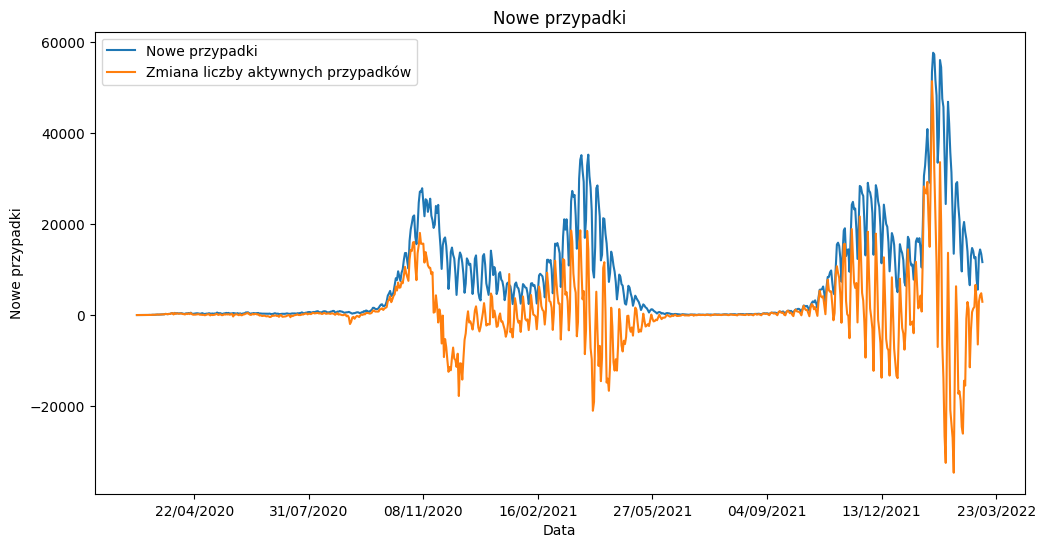

In [9]:
def visualise(df):
    plt.figure(figsize=(12, 6))
    plt.title('Nowe przypadki')
    plt.gca().xaxis.set_major_formatter(dates.DateFormatter('%d/%m/%Y'))
    plt.gca().xaxis.set_major_locator(dates.DayLocator(interval=100))
    plt.plot(df['Data'], df['Nowe przypadki'], label='Nowe przypadki')
    plt.plot(df['Data'], df['Zmiana liczby aktywnych przypadków'], label='Zmiana liczby aktywnych przypadków')
    plt.xlabel('Data')
    plt.ylabel('Nowe przypadki')
    plt.legend()
    plt.show()

visualise(df)

In [10]:
df.tail()

,Data,Nowe przypadki,Zmiana liczby aktywnych przypadków
734,2022-03-07,5585,-6470
735,2022-03-08,13152,2945
736,2022-03-09,14415,4355
737,2022-03-10,13438,4794
738,2022-03-11,11637,2917


# TODO: DOKOŃCZYĆ PREPROCESSING

In [11]:
# TODO: DOKOŃCZYĆ PREPROCESSING

## Visualisation

In [12]:
def visualise():
    plt.figure(figsize=(14, 7))
    plt.plot(df['Data'], df['Nowe przypadki'], label='Nowe przypadki')
    plt.plot(df['Data'], df['Zmiana liczby aktywnych przypadków'], label='Zmiana liczby aktywnych przypadków')
    plt.xlabel('Data')
    plt.ylabel('Liczba przypadków')
    plt.title('COVID-19 w Polsce')
    plt.legend()
    plt.show()

## Create Model

In [13]:
# class TransformerModel(nn.Module):
#     def __init__(self, input_size, output_size, num_layers, hidden_size, num_heads, dropout, embed_dim):
#         super(TransformerModel, self).__init__()
#         encoder_layer = nn.TransformerEncoderLayer(d_model=embed_dim, nhead=num_heads, dropout=dropout)
#         self.transformer_encoder = nn.TransformerEncoder(encoder_layer, num_layers=num_layers)
#         self.fc = nn.Linear(embed_dim, output_size)
#
#     def forward(self, src):
#         src = src.transpose(0, 1)
#         output = self.transformer_encoder(src)
#         output = self.fc(output[-1, :, :])
#         return output

In [14]:
class TransformerModel(nn.Module):
    def __init__(self, input_size, output_size, num_layers, hidden_size, num_heads, dropout, embed_dim):
        super(TransformerModel, self).__init__()

        self.embedding = nn.Linear(input_size, embed_dim)
        encoder_layer = nn.TransformerEncoderLayer(
            d_model=embed_dim,
            nhead=num_heads,
            dropout=dropout,
            dim_feedforward=4 * embed_dim,
        )
        # decoder_layer = nn.TransformerDecoderLayer(
        #     d_model=embed_dim,
        #     nhead=num_heads,
        #     dropout=dropout,
        #     dim_feedforward=4 * embed_dim,
        # )

        self.transformer_encoder = nn.TransformerEncoder(encoder_layer, num_layers=num_layers)
        # self.transformer_decoder = nn.TransformerDecoder(decoder_layer, num_layers=num_layers)

        self.fc = nn.Linear(embed_dim, output_size)

    # def forward(self, src, tgt):
    #     src = src.transpose(0, 1)
    #     tgt = tgt.transpose(0, 1)

    #     memory = self.transformer_encoder(src)
    #     output = self.transformer_decoder(tgt[:-1, :], memory)

    #     output = self.fc(output)
    #     return output
    def forward(self, src):
        src = self.embedding(src)
        src = src.permute(1, 0)
        output = self.transformer_encoder(src)
        output = self.fc(output[-1])
        return output



class TransformerModel(nn.Module):
    def __init__(self, input_size, output_size, num_layers, hidden_size, num_heads, dropout, embed_dim):
        super(TransformerModel, self).__init__()

        self.embedding = nn.Linear(input_size, embed_dim)
        self.transformer_encoder = TransformerEncoder(
            TransformerEncoderLayer(
                d_model=embed_dim,
                nhead=num_heads,
                dropout=dropout
            ),
            num_layers=num_layers
        )
        self.fc = nn.Linear(embed_dim, output_size)

    def forward(self, src):
        src = self.embedding(src)
        src = src.permute(1, 0)
        output = self.transformer_encoder(src)
        output = self.fc(output[-1])
        return output
        
        

## Training

In [15]:
# data = df[['Data', 'Nowe przypadki', 'Zmiana liczby aktywnych przypadków']].copy()
# data = df[['Data', 'Zmiana liczby aktywnych przypadków']].copy()

df_nowe = df[['Data', 'Nowe przypadki']].copy()
df_nowe['Data'] = pd.to_datetime(df_nowe['Data'])
df_nowe.set_index('Data', inplace=True)

data = (df_nowe - df_nowe.mean()) / df_nowe.std()

train_nowe = data.iloc[:int(0.8 * len(data))]
test_nowe = data.iloc[int(0.8 * len(data)):]

X_train_nowe = torch.tensor(train_nowe.values, dtype=torch.float32)
X_test_nowe = torch.tensor(test_nowe.values, dtype=torch.float32)
X_train_nowe

tensor([[-7.4727e-01],
        [-7.4717e-01],
        [-7.4727e-01],
        [-7.4689e-01],
        [-7.4717e-01],
        [-7.4679e-01],
        [-7.4670e-01],
        [-7.4679e-01],
        [-7.4641e-01],
        [-7.4536e-01],
        [-7.4565e-01],
        [-7.4383e-01],
        [-7.4526e-01],
        [-7.4230e-01],
        [-7.4144e-01],
        [-7.4259e-01],
        [-7.4077e-01],
        [-7.4058e-01],
        [-7.3666e-01],
        [-7.3790e-01],
        [-7.3628e-01],
        [-7.3274e-01],
        [-7.3293e-01],
        [-7.3102e-01],
        [-7.3121e-01],
        [-7.2347e-01],
        [-7.2586e-01],
        [-7.2882e-01],
        [-7.2280e-01],
        [-7.2404e-01],
        [-7.0980e-01],
        [-7.0550e-01],
        [-7.2395e-01],
        [-7.0187e-01],
        [-7.1754e-01],
        [-7.0569e-01],
        [-7.1315e-01],
        [-7.1190e-01],
        [-7.1095e-01],
        [-7.0894e-01],
        [-7.1687e-01],
        [-7.2261e-01],
        [-7.2146e-01],
        [-7

In [16]:
def train_and_evaluate(model, epochs, criterion, optimizer, X_train, X_test):
    for epoch in range(epochs):
        model.train()
        optimizer.zero_grad()
        output = model(X_train)
        loss = criterion(output, X_train)
        loss.backward()
        optimizer.step()
        if (epoch+1) % 10 == 0:
            print(f'Epoch [{epoch+1}/{epochs}], Loss: {loss.item():.4f}')

    model.eval()
    with torch.no_grad():
        predicted = model(X_test)
        predicted = predicted.detach().numpy()

## Evaluation

In [17]:
X_train_nowe.shape[1]

1

In [18]:
# import torch
# import torch.nn as nn
# from torch.nn import TransformerEncoder, TransformerEncoderLayer

# class TransformerModel(nn.Module):
#     def __init__(self, input_size, output_size, num_layers, hidden_size, num_heads, dropout, embed_dim):
#         super(TransformerModel, self).__init__()

#         self.embedding = nn.Linear(input_size, embed_dim)
#         self.transformer_encoder = TransformerEncoder(
#             TransformerEncoderLayer(
#                 d_model=embed_dim,
#                 nhead=num_heads,
#                 dropout=dropout
#             ),
#             num_layers=num_layers
#         )
#         self.fc = nn.Linear(embed_dim, output_size)

#     def forward(self, src):
#         src = self.embedding(src)
#         src = src.permute(1, 0)
#         output = self.transformer_encoder(src)
#         output = self.fc(output[-1])
#         return output
        



X_train_n = X_train_nowe[:148]

# Ustawienie rozmiaru danych wejściowych
input_size = X_train_n.shape[1]

output_size = input_size
num_layers = 3
hidden_size = 64
num_heads = 1
dropout = 0.1

# Wymiary osadzenia (embed_dim) powinny być zgodne z rozmiarem danych wejściowych
embed_dim = 148

# Utworzenie modelu Transformer
model = TransformerModel(input_size, output_size, num_layers, hidden_size, num_heads, dropout, embed_dim)

# Tworzenie kryterium straty i optymalizatora
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
epochs = 100

# Trening i ocena modelu
train_and_evaluate(model=model,
                   epochs=epochs,
                   criterion=criterion,
                   optimizer=optimizer,
                   X_train=X_train_n,  # Użyj poprawionych danych treningowych
                   X_test=X_test_nowe)


NameError: name 'TransformerEncoder' is not defined

In [44]:
import torch
import torch.nn as nn
from torch.nn import TransformerEncoder, TransformerEncoderLayer

class TransformerModel(nn.Module):
    def __init__(self, input_size, output_size, num_layers, hidden_size, num_heads, dropout, embed_dim):
        super(TransformerModel, self).__init__()

        self.embedding = nn.Linear(input_size, embed_dim)
        self.transformer_encoder = TransformerEncoder(
            TransformerEncoderLayer(
                d_model=embed_dim,
                nhead=num_heads,
                dropout=dropout
            ),
            num_layers=num_layers
        )
        self.fc = nn.Linear(embed_dim, output_size)

    def forward(self, src):
        src = self.embedding(src)
        src = src.permute(1, 0, 2)
        output = self.transformer_encoder(src)
        output = self.fc(output[-1])
        return output
        


In [45]:
def generate_data(df, sequence_length_1, sequence_length_2):
  training_data_length = math.ceil(len(df) * 0.8)

  training_data = df.iloc[:training_data_length, :1]
  testing_data = df.iloc[training_data_length:, :1]

  print("Shape of training data:", training_data.shape)
  print("Shape of testing data:", testing_data.shape)

  training_data_open = training_data.values.reshape(-1, 1)
  testing_data_open = testing_data.values.reshape(-1, 1)

  scaler = MinMaxScaler(feature_range=(0, 1))
  scaled_training_data = scaler.fit_transform(training_data_open)
  scaled_testing_data = scaler.transform(testing_data_open)

  print("Shape of scaled training data:", scaled_training_data.shape)
  print("Shape of scaled testing data:", scaled_testing_data.shape)

  X_train, y_train = [], []
  for i in range(len(scaled_training_data) - sequence_length_1):
      X_train.append(scaled_training_data[i:i+sequence_length_1])
      y_train.append(scaled_training_data[i+1:i+sequence_length_1+1])

  X_train, y_train = np.array(X_train), np.array(y_train)

  X_train = torch.tensor(X_train, dtype=torch.float32)
  y_train = torch.tensor(y_train, dtype=torch.float32)

  print("Shape of X_train:", X_train.shape)
  print("Shape of y_train:", y_train.shape)

  X_test, y_test = [], []
  for i in range(len(scaled_testing_data) - sequence_length_2):
      X_test.append(scaled_testing_data[i:i+sequence_length_2])
      y_test.append(scaled_testing_data[i+1:i+sequence_length_2+1])
  X_test, y_test = np.array(X_test), np.array(y_test)

  X_test = torch.tensor(X_test, dtype=torch.float32)
  y_test = torch.tensor(y_test, dtype=torch.float32)
  print("Shape of X_test:", X_test.shape)
  print("Shape of y_test:", y_test.shape)

  batch_size = 16
  train_dataset = torch.utils.data.TensorDataset(X_train, y_train)
  train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

  test_dataset = torch.utils.data.TensorDataset(X_test, y_test)
  test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

  return X_train, y_train, X_test, y_test, train_loader, test_loader

In [49]:
def train_nets(epochs, model, loss_fn, optimizer, X_train, y_train, X_test, y_test, loader):
    for epoch in range(epochs):
        model.train()
        for X_batch, y_batch in loader:
            optimizer.zero_grad()
            y_pred = model(X_batch)
            loss = loss_fn(y_pred, y_batch)
            loss.backward()
            optimizer.step()
        if epoch % 100 != 0:
            continue
        model.eval()
        with torch.no_grad():
            y_pred = model(X_train)
            y_pred = model(X_test)
        print("Epoch %d: train RMSE %.4f" % (epoch, loss))

    plot_results(model, X_train, X_test, y_train, y_test)

def plot_results(model, X_train, X_test, y_train, y_test):
    with torch.no_grad():
        train_plot = np.ones_like(y_train) * np.nan
        train_pred = model(X_train)
        train_plot = train_pred[:, -1].detach().numpy()
        test_plot = np.ones_like(y_test) * np.nan
        test_pred = model(X_test)
        test_plot = test_pred[:, -1].detach().numpy()
        
    x_concat = np.concatenate((np.arange(len(y_train)), np.arange(len(y_train), len(y_train) + len(y_test))))
    y_concat = np.concatenate((y_train[:, -1], y_test[:, -1]))
    plt.plot(x_concat, y_concat, label='True Data')
    plt.plot(np.arange(len(train_plot)), train_plot, label='Train Predictions', c='r', linestyle='--')
    plt.plot(np.arange(len(train_plot), len(train_plot) + len(test_plot)), test_plot, label='Test Predictions', c='g', linestyle='--')
    plt.legend()
    plt.show()

In [60]:
class TransformerEncoder(nn.Module):
    def __init__(self, input_size, num_layers, hidden_size, num_heads, dropout=0.1):
        super(TransformerEncoder, self).__init__()
        self.input_size = input_size
        self.num_layers = num_layers
        self.hidden_size = hidden_size
        self.num_heads = num_heads
        
        self.embedding = nn.Linear(input_size, hidden_size)
        self.positional_encoding = self.positional_encoding(max_len=16, d_model=hidden_size)
        
        self.layers = nn.ModuleList([
            nn.TransformerEncoderLayer(d_model=hidden_size, nhead=num_heads)
            for _ in range(num_layers)
        ])
        
        self.dropout = nn.Dropout(dropout)
        
        self.fc_out = nn.Linear(hidden_size, 1)
        
    def forward(self, x):
        seq_len = x.size(1)
        positional_encoding = self.positional_encoding[:, :seq_len, :]
        
        x = self.embedding(x) + positional_encoding
        x = x.permute(1, 0, 2)  # Change to shape (seq_len, batch_size, hidden_size)
        
        for layer in self.layers:
            x = layer(x)
        
        x = x.permute(1, 0, 2)  # Change back to shape (batch_size, seq_len, hidden_size)
        x = self.fc_out(x)
        return x[:, -1, :]  # Predict only the last time step
    
    def positional_encoding(self, max_len, d_model):
        position = torch.arange(0, max_len).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2) * -(np.log(10000.0) / d_model))
        pe = torch.zeros(max_len, 1, d_model)
        pe[:, 0, 0::2] = torch.sin(position * div_term)
        pe[:, 0, 1::2] = torch.cos(position * div_term)
        return pe

# Example usage
model = TransformerEncoder(input_size=1, num_layers=2, hidden_size=64, num_heads=2)

In [62]:
X_train, y_train, X_test, y_test, train_loader, test_loader = generate_data(df_nowe, 16, 20)
input_size=1 
hidden_size=10 
output_size=1
num_layers=2
num_heads=3
dropout=0.5
embed_dim=num_heads*hidden_size
# model = TransformerModel(input_size, output_size, num_layers, hidden_size, num_heads, dropout, embed_dim)

# Tworzenie kryterium straty i optymalizatora
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
epochs = 100

# rnn = RNN_Net(input_size=1, hidden_size=10, output_size=1, num_layers=2)
# criterion_rnn = nn.MSELoss()
# optimizer_rnn = optim.Adam(rnn.parameters(), lr=0.001)
train_nets(epochs, model, criterion, optimizer, X_train, y_train, X_test, y_test, train_loader)

Shape of training data: (592, 1)
Shape of testing data: (147, 1)
Shape of scaled training data: (592, 1)
Shape of scaled testing data: (147, 1)
Shape of X_train: torch.Size([576, 16, 1])
Shape of y_train: torch.Size([576, 16, 1])
Shape of X_test: torch.Size([127, 20, 1])
Shape of y_test: torch.Size([127, 20, 1])


/opt/conda/lib/python3.10/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([16, 16, 1])) that is different to the input size (torch.Size([16, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


RuntimeError: The size of tensor a (576) must match the size of tensor b (16) at non-singleton dimension 0

In [40]:
class RNN_Net(nn.Module):
    def __init__(self, input_size=1, hidden_size=32, output_size=1, num_layers=1):
        super(RNN_Net, self).__init__()
        self.hidden_size = hidden_size
        self.hidden_size_1 = hidden_size
        self.hidden_size_2 = hidden_size
        self.rnn_1 = nn.RNN(input_size, hidden_size, batch_first=True)
        self.rnn_2 = nn.RNN(hidden_size, hidden_size, batch_first=True)
        self.layer_norm_1 = nn.LayerNorm(hidden_size)
        self.layer_norm_2 = nn.LayerNorm(hidden_size)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        batch_size = x.size(0)
        h0 = torch.zeros(1, batch_size, self.hidden_size)
        h1 = torch.zeros(1, batch_size, self.hidden_size_1)
        h2 = torch.zeros(1, batch_size, self.hidden_size_2)
        out1, _ = self.rnn_1(x, h0)
        out2, _ = self.rnn_2(out1, h1)
        out1 = self.layer_norm_1(out1)
        out2 = self.layer_norm_2(out2)
        out = self.fc(out2)
        return out


In [41]:
def train_nets(epochs, model, loss_fn, optimizer, X_train, y_train, X_test, y_test, loader):
    for epoch in range(epochs):
        model.train()
        for X_batch, y_batch in loader:
            optimizer.zero_grad()
            y_pred = model(X_batch)
            loss = loss_fn(y_pred, y_batch)
            loss.backward()
            optimizer.step()
        if epoch % 10 != 0:
            continue
        model.eval()
        with torch.no_grad():
            y_pred = model(X_train)
            train_rmse = np.sqrt(loss_fn(y_pred, y_train))
            y_pred = model(X_test)
            test_rmse = np.sqrt(loss_fn(y_pred, y_test))
        print("Epoch %d: train RMSE %.4f, test RMSE %.4f" % (epoch, train_rmse, test_rmse))

    plot_results(model, X_train, X_test, y_train, y_test)

def plot_results(model, X_train, X_test, y_train, y_test):
    with torch.no_grad():
        train_plot = np.ones_like(y_train) * np.nan
        train_pred = model(X_train)
        train_plot = train_pred[:, -1, 0].detach().numpy()
        test_plot = np.ones_like(y_test) * np.nan
        test_pred = model(X_test)
        test_plot = test_pred[:, -1, 0].detach().numpy()
        
    x_concat = np.concatenate((np.arange(len(y_train)), np.arange(len(y_train), len(y_train) + len(y_test))))
    y_concat = np.concatenate((y_train[:, -1, 0], y_test[:, -1, 0]))
    plt.plot(x_concat, y_concat, label='True Data')
    plt.plot(np.arange(len(train_plot)), train_plot, label='Train Predictions', c='r', linestyle='--')
    plt.plot(np.arange(len(train_plot), len(train_plot) + len(test_plot)), test_plot, label='Test Predictions', c='g', linestyle='--')
    plt.legend()
    plt.show()

Shape of training data: (592, 1)
Shape of testing data: (147, 1)
Shape of scaled training data: (592, 1)
Shape of scaled testing data: (147, 1)
Shape of X_train: torch.Size([585, 7, 1])
Shape of y_train: torch.Size([585, 7, 1])
Shape of X_test: torch.Size([127, 20, 1])
Shape of y_test: torch.Size([127, 20, 1])
Epoch 0: train RMSE 0.1430, test RMSE 0.3684
Epoch 10: train RMSE 0.0576, test RMSE 0.1845
Epoch 20: train RMSE 0.0591, test RMSE 0.1848
Epoch 30: train RMSE 0.0552, test RMSE 0.1766
Epoch 40: train RMSE 0.0559, test RMSE 0.1656
Epoch 50: train RMSE 0.0574, test RMSE 0.1673
Epoch 60: train RMSE 0.0543, test RMSE 0.1753
Epoch 70: train RMSE 0.0547, test RMSE 0.1768
Epoch 80: train RMSE 0.0536, test RMSE 0.1744
Epoch 90: train RMSE 0.0539, test RMSE 0.1747


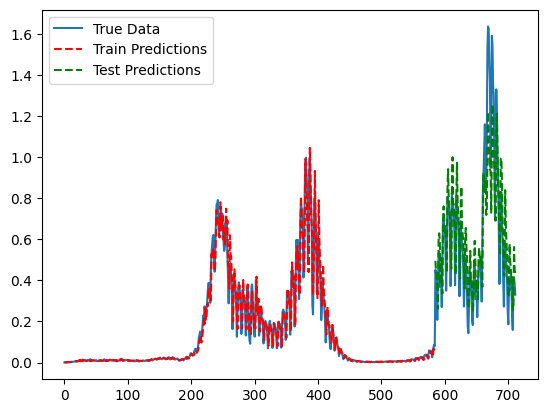

In [43]:
X_train, y_train, X_test, y_test, train_loader, test_loader = generate_data(df_nowe, 7, 20)
rnn = RNN_Net(input_size=1, hidden_size=10, output_size=1, num_layers=2)
criterion_rnn = nn.MSELoss()
optimizer_rnn = optim.Adam(rnn.parameters(), lr=0.001)
train_nets(100, rnn, criterion_rnn, optimizer_rnn, X_train, y_train, X_test, y_test, train_loader)

## Conclusion

In [ ]:
# TODO: POLECENIE:
#  Do testowania proszę użyć kilku podejść podziału danych na uczące- testujace:
#  (https://hub.packtpub.com/cross-validation-strategies-for-time-series-forecasting-tutorial/)
#  -K-Fold, Time SeriesSplit, Blocking Time Series Split
#  Dla każdego wyniku stosujemy różne miary błędu (ewaluacji) MSE, MAE, R^2,  specyficzność czułość, index of agreement itp..